In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import shapefile as shp

%matplotlib widget

## 0.1 Load in imagery

In [2]:
with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

## 1. Load the DEMs and put them into arrays

In [3]:
## Bed DEM
src_bed = rasterio.open('../DEMs/merged_AH_bed_topo_fix_smooth_100m.tif')
bed_arr = src_bed.read(1)

## Surface DEM
src_surf = rasterio.open('../DEMs/rema_100m_resamp.tif')
surf_arr = src_surf.read(1)

Text(0.5, 1.0, 'Surface DEM')

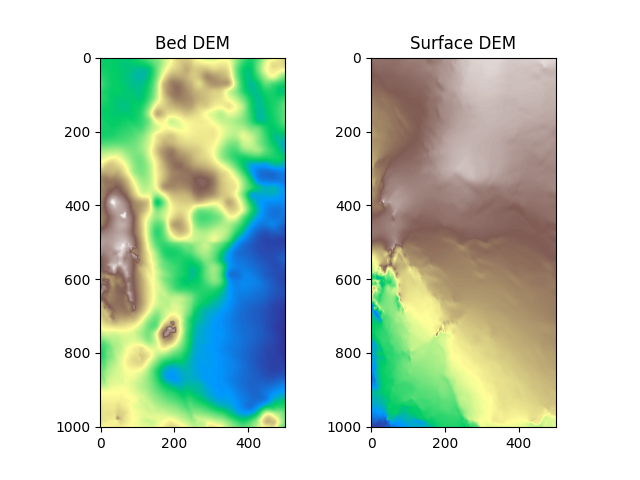

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(bed_arr, cmap='terrain', vmin=bed_arr.min(), vmax=bed_arr.max())
ax2.imshow(surf_arr, cmap='terrain', vmin=surf_arr.min(), vmax=surf_arr.max())

ax1.set_title('Bed DEM')
ax2.set_title('Surface DEM')

## 2. Calculate the slope of the bed and surface

In [5]:
cellsize = 100.0   # Assuming square pixels

px, py = np.gradient(bed_arr, cellsize)
slope_bed = np.sqrt(px ** 2 + py ** 2)
aspect = np.arctan2(py, -px)
aspect = np.degrees(aspect)
aspect_bed = (aspect + 360) % 360  # Convert to 0-360 degrees

px, py = np.gradient(surf_arr, cellsize)
slope_surf = np.sqrt(px ** 2 + py ** 2)
aspect = np.arctan2(py, -px)
aspect = np.degrees(aspect)
aspect_surf = (aspect + 360) % 360  # Convert to 0-360 degrees

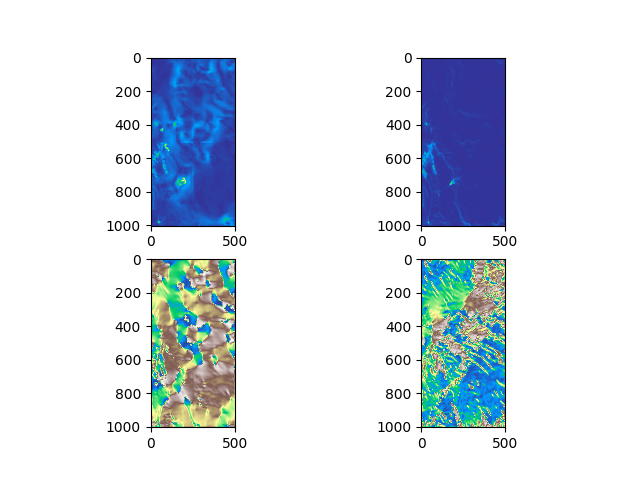

In [6]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)

ax1.imshow(slope_bed, cmap='terrain', vmin=slope_bed.min(), vmax=slope_bed.max())
ax2.imshow(slope_surf, cmap='terrain', vmin=slope_surf.min(), vmax=slope_surf.max())

ax3.imshow(aspect_bed, cmap='terrain', vmin=aspect_bed.min(), vmax=aspect_bed.max())
ax4.imshow(aspect_surf, cmap='terrain', vmin=aspect_surf.min(), vmax=aspect_surf.max())


## 3. Calculate driving stress coefficient

In [7]:
drive_stress_coeff = np.sin(slope_bed) - np.tan(slope_bed - slope_surf)

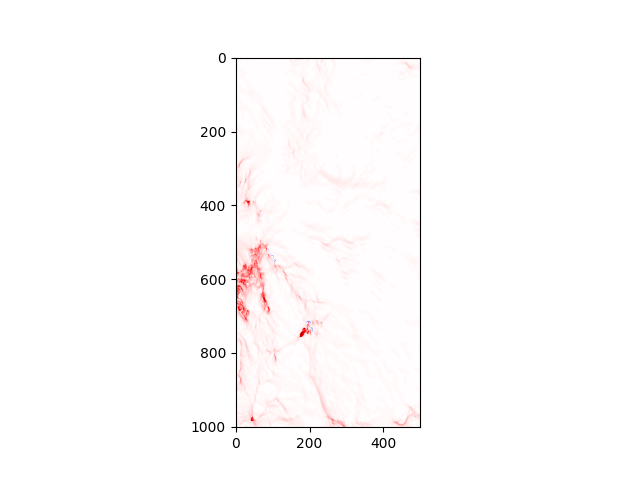

In [8]:
fig, ax = plt.subplots()

ax.imshow(drive_stress_coeff, cmap='seismic', vmin=-1, vmax=1)

## 4. Calculate the difference in aspect

In [9]:
aspect_diff = np.abs(np.abs(np.abs(aspect_bed - aspect_surf) - 180) - 180)
aspect_diff_ratio = aspect_diff / 180.0

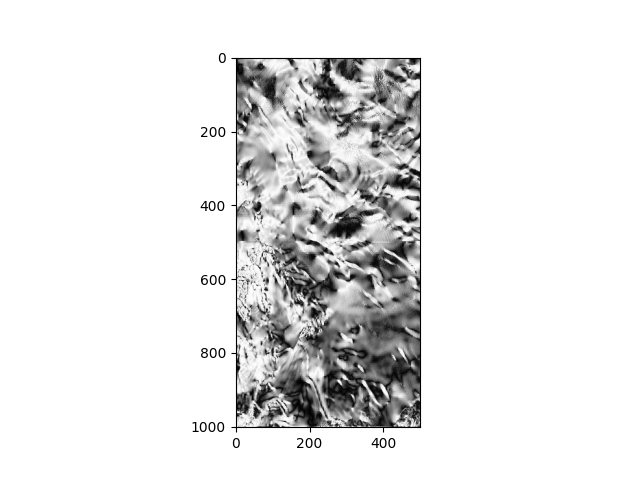

In [10]:
# fig, ax = plt.subplots()

# ax.imshow(aspect_diff, cmap='Greys', vmin=0, vmax=180)

fig, ax = plt.subplots()

ax.imshow(aspect_diff_ratio, cmap='Greys', vmin=0, vmax=1)

## 5.0 Calculate a coefficient that combines the driving stress and the difference in aspects between surface and bed slopes

In [11]:
old_ice = np.abs(drive_stress_coeff) * aspect_diff_ratio

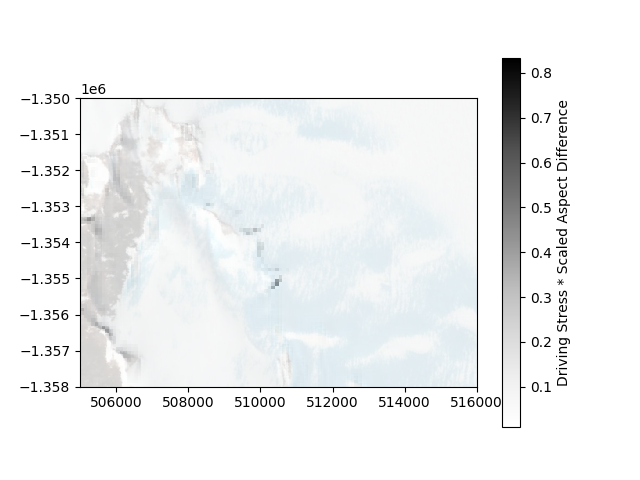

In [12]:
fig,ax = plt.subplots()


im = ax.imshow(old_ice, cmap='Greys', vmin=.01, vmax=old_ice.max())
show(image_data, ax=ax, transform=src1.transform)

show(old_ice, transform=src_bed.transform, alpha=0.8, ax=ax, cmap='Greys', vmin=.01, vmax=old_ice.max())

ax.set_xlim([505000, 516000])
ax.set_ylim([-1.358e6, -1.35e6])

plt.colorbar(im, ax=ax, orientation='vertical', label='Driving Stress * Scaled Aspect Difference')
# plt.savefig('old_ice_loc.png', dpi=300, bbox_inches='tight')

## 5.1 Plot this with borehole locations

In [13]:
sf = shp.Reader("../Borehole_Locations/AH_core_locations_reproj.shp")

shapes = sf.shapes()
records = sf.records()

list_of_boreholes = ['ALHIC1902', 'ALHIC1903', 'ALHIC1901', 'ALHIC2201', 'ALHIC2301']

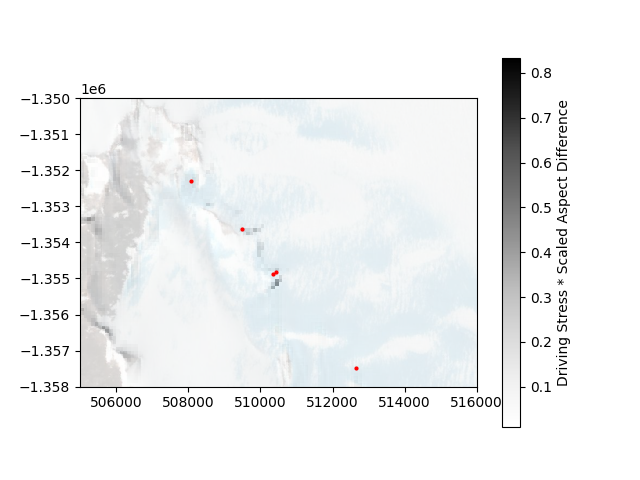

In [14]:
fig,ax = plt.subplots()


im = ax.imshow(old_ice, cmap='Greys', vmin=.01, vmax=old_ice.max())
show(image_data, ax=ax, transform=src1.transform)

show(old_ice, transform=src_bed.transform, alpha=0.8, ax=ax, cmap='Greys', vmin=.01, vmax=old_ice.max())

## Borehole locations
for shape, record in zip(shapes,records):
    points = shape.points
    x, y = zip(*points)

    if record[0] in list_of_boreholes:
        ax.plot(x, y, 'o',color='red', markersize=2)

ax.set_xlim([505000, 516000])
ax.set_ylim([-1.358e6, -1.35e6])


plt.colorbar(im, ax=ax, orientation='vertical', label='Driving Stress * Scaled Aspect Difference')

plt.savefig('old_ice_loc.png', dpi=300, bbox_inches='tight')

## 6.0 Save old ice array to tiff



In [20]:
driver = "GTiff"
height = old_ice.shape[0]
width = old_ice.shape[1]
transform = src_bed.transform
dtype = old_ice.dtype
crs = src_bed.crs

with rasterio.open('old_ice_loc.tif', 'w', driver=driver, height=height, width=width,
                   count=1, dtype=dtype, crs=crs, transform=transform) as dst:
    dst.write(old_ice, 1)